In [1]:
import datetime as dt

import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import seaborn as sns
from jax import random
from numpyro.infer import MCMC, NUTS
from scipy.special import expit
from sklearn.preprocessing import LabelEncoder
import geopandas as gpd

assert numpyro.__version__.startswith("0.8.0")
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'axes.grid': True,
                     'grid.linestyle': ':',
                     'axes.spines.bottom': False,
          'axes.spines.left': False,
          'axes.spines.right': False,
          'axes.spines.top': False})

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


### Download sequences

In [2]:
! bash scripts/pipeline.sh

+ bash scripts/download_data.sh
+ mkdir -p data/compressed
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Sequenzdaten_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   210  100   210    0     0    342      0 --:--:-- --:--:-- --:--:--   342
100 27.9M  100 27.9M    0     0   799k      0  0:00:35  0:00:35 --:--:-- 1859k
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Entwicklungslinien_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   216  100   216    0     0    251      0 --:--:-- --:--:-- --:--:--   251
100 10.7M  100 10.7M    0     0  2820k      0  0:00:03  0:00:03 --:--:-- 4528k
+ bash scripts/

### Download geodata

In [3]:
#plz = gpd.read_file("https://opendata.arcgis.com/datasets/5b203df4357844c8a6715d7d411a8341_0.geojson")
plz = gpd.read_file("data/5b203df4357844c8a6715d7d411a8341_0.geojson")
bland = plz.set_index("plz")['bundesland']

### Load data

In [4]:
df = pd.read_csv(
    'data/meta_lineages.csv',
    index_col=0,
    parse_dates=[1,3],
    infer_datetime_format=True,
    cache_dates=True,
    dtype = {'SEQ_REASON': 'category',
             'SENDING_LAB_PC': 'category',
             'SEQUENCING_LAB_PC': 'category',
             'lineage': 'category',
             'scorpio_call': 'category'
             }
)
df.rename(columns={
    'DATE_DRAW': 'date',
    'PROCESSING_DATE': 'processing_date',
    'SEQ_REASON': 'reason',
    'SENDING_LAB_PC': 'sending_pc',
    'SEQUENCING_LAB_PC': 'sequencing_pc',
    'lineage': 'lineage',
    'scorpio_call': 'scorpio'
    },
    inplace=True
)

In [5]:
df = df[df.date >= '2021-11-01']
df = df[df.reason.isin(['N'])]
df['omi'] = df.lineage.apply(lambda x: int((x in ['B.1.1.529','BA.1','BA.2', 'BA.3']))) 
all = df.groupby(['sending_pc','date'])['omi'].count()#
omi = df.groupby(['sending_pc','date'])['omi'].apply(lambda x: (x == 1).sum()).fillna(0).astype(int)
df_reshaped = pd.concat({'all': all, 'omi': omi}, axis=1).reset_index()
today = pd.Timestamp(str(dt.date.today()))
df_reshaped['days'] = (df_reshaped.date-today).dt.days
df_reshaped['sending_area'] = df_reshaped.sending_pc.apply(lambda x: int(x[0]))
lab_counts = df_reshaped[df_reshaped.date > '2021-12-01'].groupby('sending_pc')['all'].sum()
# df_filtered = df_reshaped[df_reshaped.sending_pc.isin(lab_counts[lab_counts>10].index) & (~df_reshaped.sending_pc.isin(['']))].copy()
df_filtered = df_reshaped[df_reshaped.sending_pc.isin(lab_counts[lab_counts>10].index) & (~df_reshaped.sending_pc.isin(['22767','70193','24106']))].copy().dropna()
le = LabelEncoder()
df_filtered['sending_pc_ID'] = le.fit_transform(df_filtered['sending_pc'].values)

df_filtered = df_filtered.merge(bland, left_on='sending_pc', right_index=True)#.dropna()
df_filtered['bundesland'] = pd.Categorical(df_filtered['bundesland'].values)

omi_counts = df_filtered["omi"].values
total_counts = df_filtered["all"].values
sample_day = df_filtered["days"].values
sending_pc_ID = df_filtered['sending_pc_ID'].values
sending_area = df_filtered['bundesland'].values.codes

In [6]:
df_filtered

sending_pc       date  all  omi  days  sending_area  sending_pc_ID  \
0          01067 2021-11-01    0    0   -84             0              0   
1          01067 2021-11-02    8    0   -83             0              0   
2          01067 2021-11-03    0    0   -82             0              0   
3          01067 2021-11-04   69    0   -81             0              0   
4          01067 2021-11-05    0    0   -80             0              0   
...          ...        ...  ...  ...   ...           ...            ...   
20298      90530 2022-01-14    0    0   -10             9            102   
20299      90530 2022-01-15    0    0    -9             9            102   
20300      90530 2022-01-16    0    0    -8             9            102   
20301      90530 2022-01-17    0    0    -7             9            102   
20302      90530 2022-01-18    0    0    -6             9            102   

      bundesland  
0        Sachsen  
1        Sachsen  
2        Sachsen  
3        Sachsen  
4        Sachsen  
...          ...  
20298     Bayern  
20299     Bayern  
20300     Bayern  
20301     Bayern  
20302     Bayern  

[9401 rows x 8 columns]

Text(0, 0.5, 'Proportion')

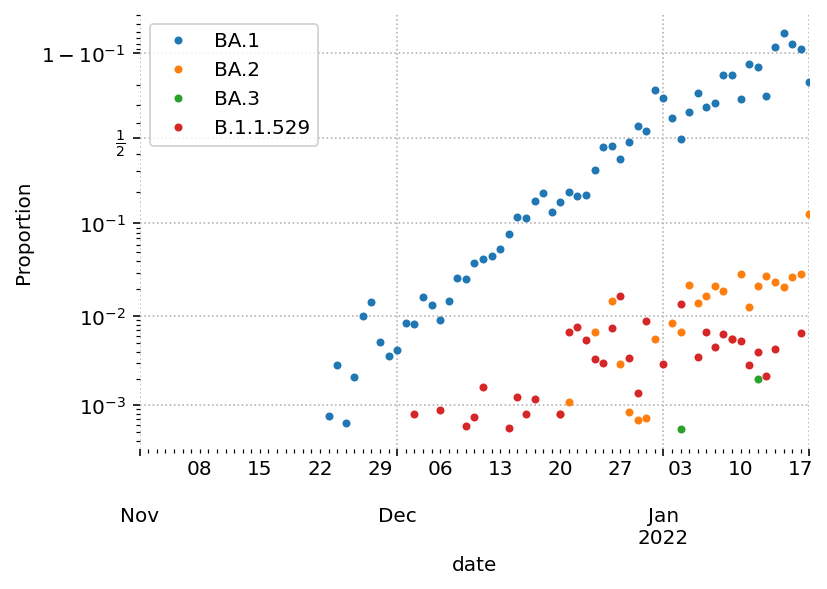

In [7]:
foo = pd.crosstab(df.date, df.lineage.cat.remove_unused_categories())
for i in ['BA.1','BA.2','BA.3','B.1.1.529']:
    (foo[i]/foo.sum(1)).plot(ls="",marker='.', label=i)
plt.yscale('logit')
plt.legend()
plt.ylabel('Proportion')

In [8]:
print(foo.loc["2021-12-01":,:].sum(0).sort_values().to_string())

lineage
B                 0
AY.37             0
AY.46.4           0
AY.55             0
AY.107            0
AY.66             0
AY.67             0
AY.89             0
AY.91.1           0
AY.23.2           0
AY.5.2            0
AY.27             0
AY.16             0
B.1.351           0
B.1.639           0
AU.2              0
AY.46.3           0
AY.3.1            0
B.1.1.7           0
AY.43.3           0
AY.43.2           0
AY.81             1
AY.50             1
AY.52             1
AY.53             1
AY.54             1
AY.58             1
AY.60             1
AY.11             1
AY.82             1
AY.39.1.1         1
AY.95             1
AY.99.2           1
AY.19             1
AY.119.1          1
AY.23.1           1
AY.46.5           1
AY.77             1
AY.104            1
B.1.110           1
AY.105            1
AY.62             1
B.1.497           1
B.1.1             1
B.1.367           1
AY.13             1
AY.93             1
BA.3              2
B.1.1.263         2
AY.43.5     

(18951.0, 19016.0)

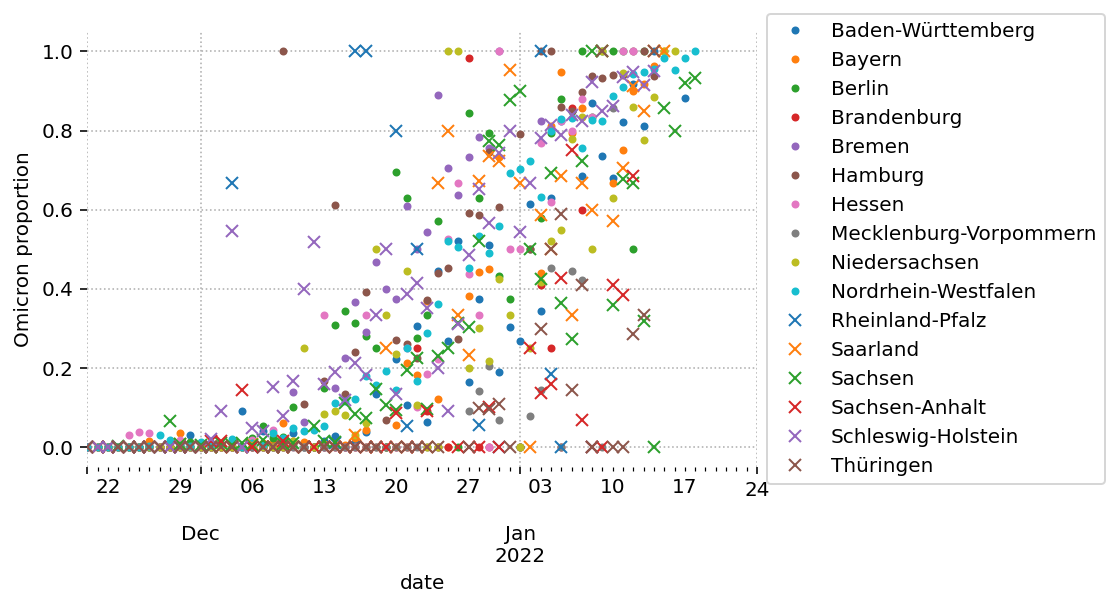

In [9]:
omi_bl = df_filtered.set_index(['bundesland','sending_pc','date']).sort_index()
omi_bl = omi_bl.sum(level=[0,2]).loc[:,"2021-11-20":,:]
omi_bl['prop'] = omi_bl.omi / omi_bl['all']
for i,r in enumerate(omi_bl.index.levels[0]):
    omi_bl.loc[r]['prop'].plot(ls="", marker="." if i < 10 else "x", label=r)
#omi_bl.mean(level=1)['prop'].plot()
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
#plt.yscale('logit')
plt.ylabel("Omicron proportion")
plt.xlim((None, np.datetime64("today")))

In [10]:
from numpyro.infer.reparam import LocScaleReparam
import jax.numpy as jnp
#reparam_config = {k: LocScaleReparam(0) for k in ["a_area", "a_lab", "b"]}

#@numpyro.handlers.reparam(config=reparam_config)
def model3(sending_pc, sending_area, sending_pc_to_area, sample_day, total_counts,omi_counts=None):
    mu_a = numpyro.sample("mu_a", dist.Normal(0, 5.0))
    sigma_a_area = numpyro.sample("sigma_a_area", dist.HalfNormal(5.0))
    #sigma_a_lab = numpyro.sample("sigma_a_lab", dist.HalfNormal(2.))
    mu_b = numpyro.sample("mu_b", dist.Normal(0.2, 0.2))
    sigma_b_area = numpyro.sample("sigma_b_area", dist.HalfNormal(.1))
    #sigma_b_lab = numpyro.sample("sigma_b_lab", dist.HalfNormal(.01))


    n_labs = len(np.unique(sending_pc))
    n_areas = len(np.unique(sending_pc_to_area))

    with numpyro.plate("plate_i", n_areas):
        a_area = numpyro.sample("a_area", dist.Normal(mu_a, sigma_a_area))
        b = numpyro.sample("b", dist.Normal(mu_b, sigma_b_area))

    #with numpyro.plate("plate_j", n_labs):
    #    a_lab = numpyro.sample("a_lab", dist.Normal(0, sigma_a_lab))
        #b_lab = numpyro.sample("b_lab", dist.Normal(0, 0.01))


    logit_est =  a_area[sending_area] + b[sending_area] * sample_day #a_lab[sending_pc] +
        
    rho = 20.
    alpha = rho * jnp.clip(jnp.exp(logit_est), 1e-9, 1e9)

    with numpyro.plate("data", len(sending_pc)):
        #numpyro.sample("obs", dist.BinomialLogits(logits=logit_est, total_count=total_counts), obs=omi_counts)
        numpyro.sample("obs", dist.BetaBinomial(concentration1 = alpha, concentration0 = rho, total_count=total_counts), obs=omi_counts)



In [11]:
sending_pc_to_area = pd.DataFrame({"sending_pc": sending_pc_ID, "sending_area": sending_area}).groupby(['sending_pc']).sending_area.first().values

In [12]:
nuts_kernel = NUTS(model3, init_strategy=numpyro.infer.init_to_median)#, dense_mass=[("mu_a","mu_b","sigma_a_area","sigma_a_lab","sigma_b_area")])

mcmc = MCMC(nuts_kernel, num_samples=500, num_warmup=500)
rng_key = random.PRNGKey(42)
mcmc.run(rng_key, sending_pc_ID, sending_area, sending_pc_to_area, sample_day, total_counts, omi_counts=omi_counts)

sample: 100%|██████████| 1000/1000 [03:55<00:00,  4.25it/s, 31 steps of size 1.56e-01. acc. prob=0.88] 


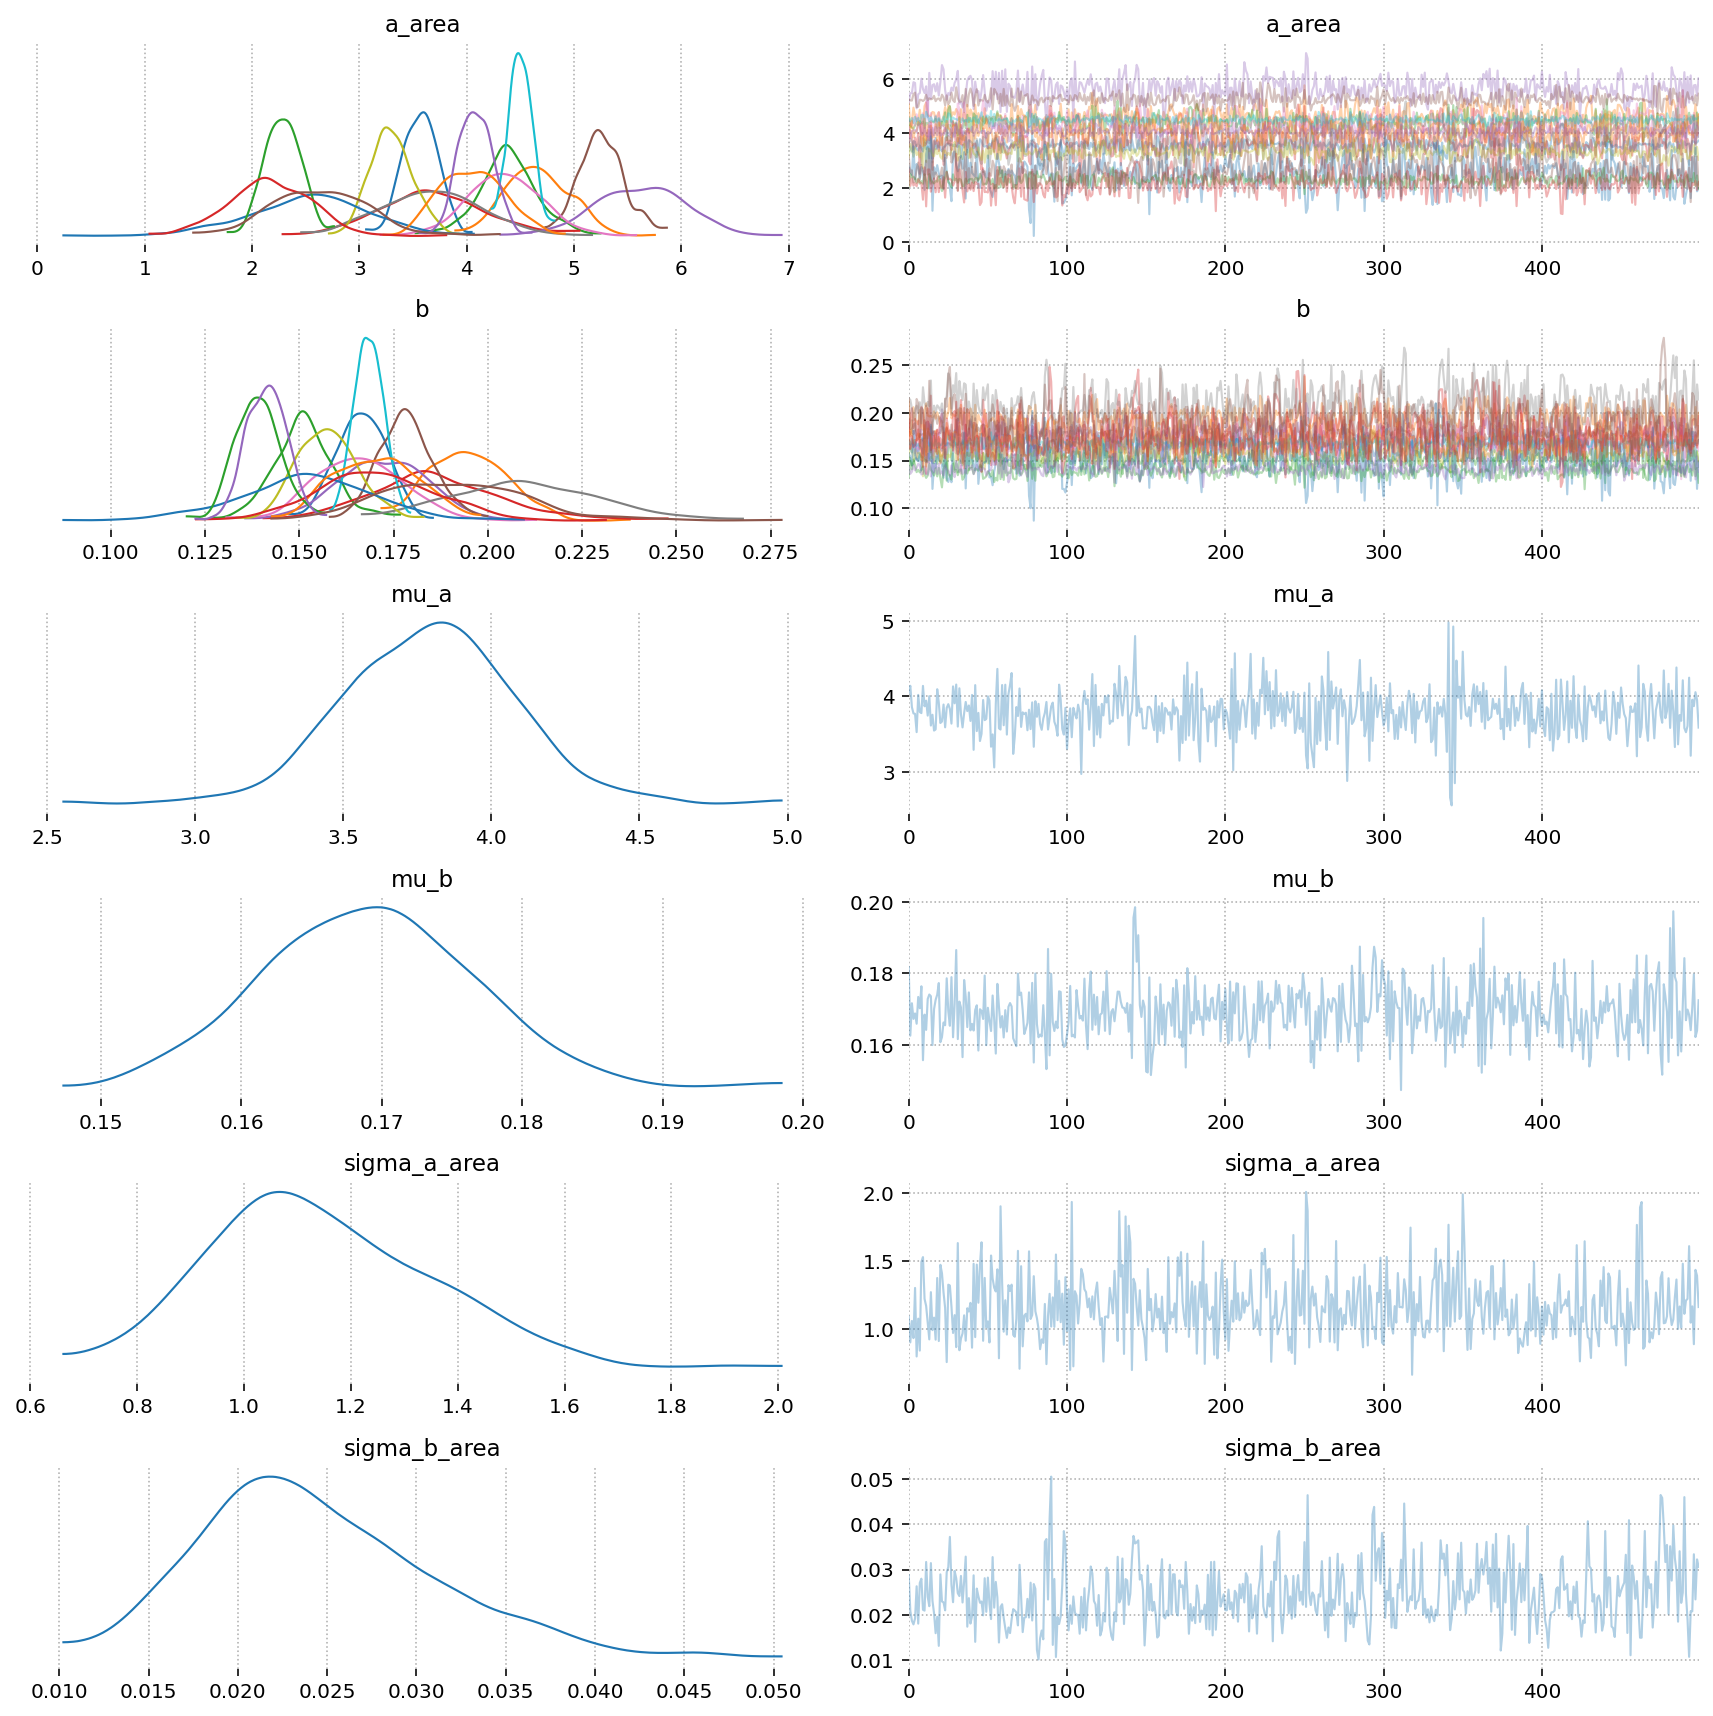

In [13]:
data = az.from_numpyro(mcmc)
az.plot_trace(data,compact=True)
plt.tight_layout()

In [14]:
mcmc_samples = mcmc.get_samples(group_by_chain=True)
mcmc_summary = numpyro.diagnostics.summary(mcmc_samples)

print(f"""
    Relatives tägliches Wachstum von Omikron gegenüber Delta:
    {np.exp(mcmc_summary['mu_b']['mean'])-1:.1%} mit 90%-Konfidenzintervall [{np.exp(mcmc_summary['mu_b']['5.0%'])-1:.1%}, {np.exp(mcmc_summary['mu_b']['95.0%'])-1:.1%}]
    Relative Verdopplungszeit von Omikron gegenüber Delta:
    {np.log(2)/np.log(1+mcmc_summary['mu_b']['mean']):.2} Tage mit 90%-Konfidenzintervall [{np.log(2)/np.log(1+mcmc_summary['mu_b']['95.0%']):.2},{np.log(2)/np.log(1+mcmc_summary['mu_b']['5.0%']):.2}]
    """)


    Relatives tägliches Wachstum von Omikron gegenüber Delta:
    18.4% mit 90%-Konfidenzintervall [16.9%, 19.8%]
    Relative Verdopplungszeit von Omikron gegenüber Delta:
    4.4 Tage mit 90%-Konfidenzintervall [4.2,4.8]
    


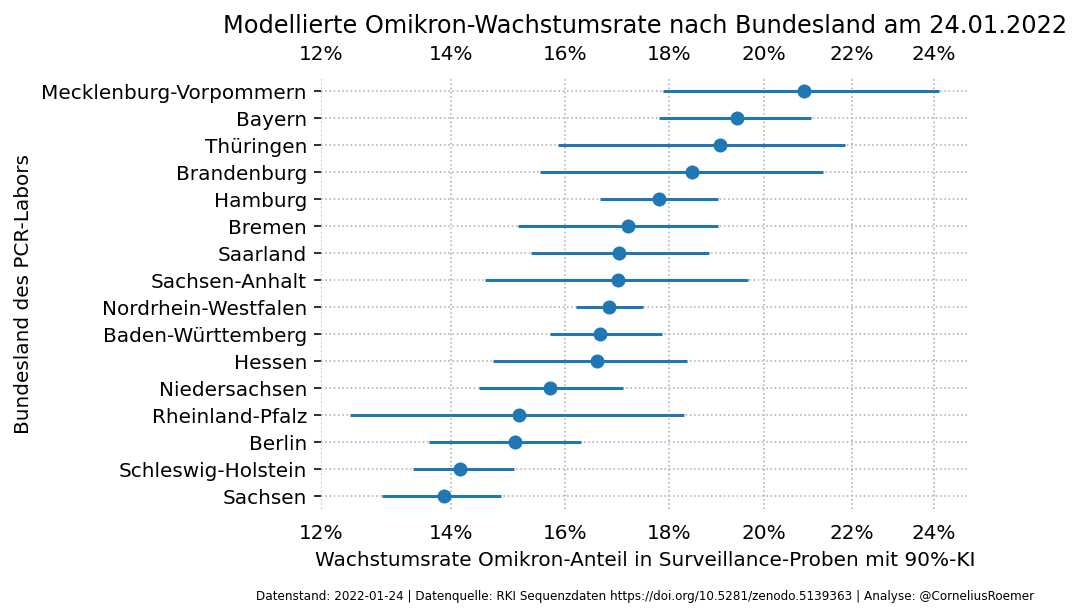

In [15]:
nice_formatter = ticker.FuncFormatter(
    lambda y, _: f'{ np.format_float_positional(100*y, trim="-", precision=6).rstrip(".")}%'
)
pdf = pd.DataFrame(mcmc_summary['b'], index=df_filtered.bundesland.values.categories)
pdf.sort_values(by='median',inplace=True)
errors = ([(pdf['median'])-(pdf['5.0%']),(pdf['95.0%'])-(pdf['median'])])
fig, ax = plt.subplots(figsize=(5,4)) 
#sns.set_theme(style="whitegrid")
ax.errorbar(x=(pdf['median'].values),y=pdf.index.values.astype(str),xerr=errors,linestyle='None',marker='o')
#sns.despine(left=True, bottom=True)
ax.set(title='Title')
ax.set_ylim(-0.5,len(pdf)-0.5)
ax.set_xscale('logit')
ax.xaxis.set_major_formatter(nice_formatter)
ax.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=True)
ax.tick_params(axis='both', which='minor', labelbottom = False, bottom=False, top = False, labeltop=False)
ax.set(title=f'Modellierte Omikron-Wachstumsrate nach Bundesland am {today.strftime("%d.%m.%Y")}')
ax.set_ylabel("Bundesland des PCR-Labors")
ax.set_xlabel("Wachstumsrate Omikron-Anteil in Surveillance-Proben mit 90%-KI")
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.15)
fig.text(0.5, -0.01, f"Datenstand: {str(dt.date.today())} | Datenquelle: RKI Sequenzdaten https://doi.org/10.5281/zenodo.5139363 | Analyse: @CorneliusRoemer", size=6, va="bottom", ha="center")
fig.savefig("plots/omi_share_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [16]:
list(df_filtered.bundesland.values.categories)

['Baden-Württemberg',
 'Bayern',
 'Berlin',
 'Brandenburg',
 'Bremen',
 'Hamburg',
 'Hessen',
 'Mecklenburg-Vorpommern',
 'Niedersachsen',
 'Nordrhein-Westfalen',
 'Rheinland-Pfalz',
 'Saarland',
 'Sachsen',
 'Sachsen-Anhalt',
 'Schleswig-Holstein',
 'Thüringen']

In [17]:
q = [0.05,0.5,0.95]
t = (np.arange("2021-11-20","2022-01-31", dtype='datetime64[D]') - np.datetime64("today")).astype("int")
prop_bl = pd.Series(expit(np.quantile(mcmc_samples['a_area'][0][...,np.newaxis] + mcmc_samples['b'][0][...,np.newaxis] * t[np.newaxis,np.newaxis,:], 
                                     q,
                                     axis = 0)).flatten(),
                         index = pd.MultiIndex.from_product([q, 
                                                             df_filtered.bundesland.values.categories,
                                                             np.datetime64("today") + t.astype("timedelta64[D]")],
                                                           names=['quantile',
                                                                  'bundesland',
                                                                  'date']),
                       )
prop_bl = prop_bl.reset_index().set_index(["bundesland","date","quantile"])#.pivot(columns="quantile")

In [18]:
prop_bl

0
bundesland        date       quantile          
Baden-Württemberg 2021-11-20 0.05      0.000446
                  2021-11-21 0.05      0.000533
                  2021-11-22 0.05      0.000637
                  2021-11-23 0.05      0.000762
                  2021-11-24 0.05      0.000910
...                                         ...
Thüringen         2022-01-26 0.95      0.977539
                  2022-01-27 0.95      0.981737
                  2022-01-28 0.95      0.985163
                  2022-01-29 0.95      0.987954
                  2022-01-30 0.95      0.990225

[3456 rows x 1 columns]

In [19]:
omi_bl

all  omi  days  sending_area  sending_pc_ID  \
bundesland        date                                                      
Baden-Württemberg 2021-11-20  126    0  -845            91           1138   
                  2021-11-21   93    0  -832            91           1138   
                  2021-11-22  543    0  -819            91           1138   
                  2021-11-23  123    0  -806            91           1138   
                  2021-11-24   50    0  -793            91           1138   
...                           ...  ...   ...           ...            ...   
Thüringen         2022-01-14    3    3   -40            27            336   
                  2022-01-15    0    0   -36            27            336   
                  2022-01-16    0    0   -32            27            336   
                  2022-01-17    0    0   -28            27            336   
                  2022-01-18    0    0   -24            27            336   

                              prop  
bundesland        date              
Baden-Württemberg 2021-11-20   0.0  
                  2021-11-21   0.0  
                  2021-11-22   0.0  
                  2021-11-23   0.0  
                  2021-11-24   0.0  
...                            ...  
Thüringen         2022-01-14   1.0  
                  2022-01-15   NaN  
                  2022-01-16   NaN  
                  2022-01-17   NaN  
                  2022-01-18   NaN  

[960 rows x 6 columns]

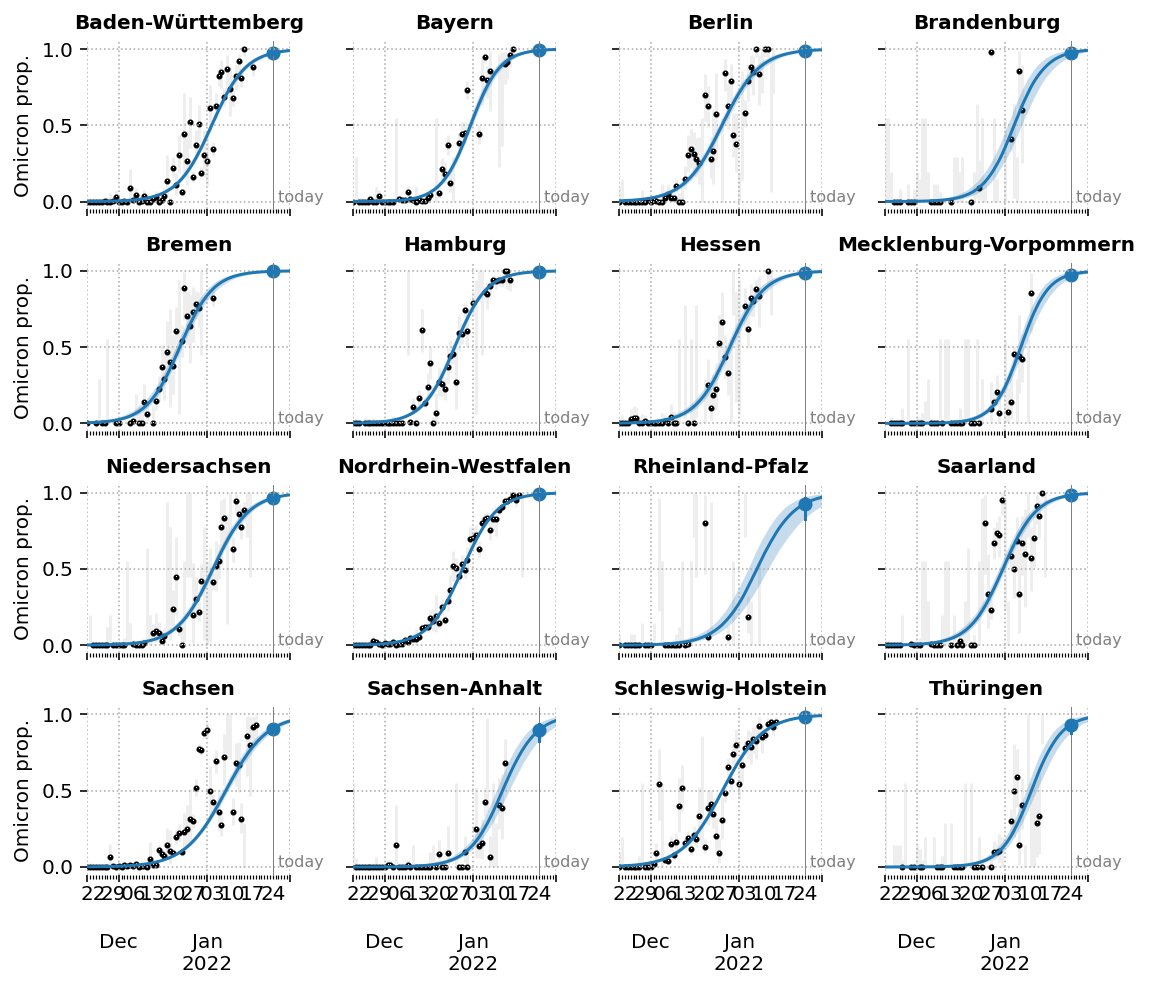

In [20]:
#sns.reset_orig()
plt.rcParams['figure.facecolor'] = 'white'
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
for i,r in enumerate(prop_bl.index.levels[0]):
    prop_bl.loc[r,:,0.5][0].plot(label=r, ax=ax[i])
    ax[i].fill_between(prop_bl.loc[r,:,0.05][0].index, prop_bl.loc[r,:,0.05][0], prop_bl.loc[r,:,0.95][0], alpha=0.25)
    ax[i].axvline(np.datetime64("today"), color='grey', lw=0.5)
    ax[i].text(np.datetime64("today"),0.0, " today", size=8, color='grey')
    ax[i].plot(np.repeat(np.datetime64("today"),2), prop_bl.loc[r,np.datetime64("today"),[0.05,0.95]], c='C0')
    ax[i].scatter(np.datetime64("today"), prop_bl.loc[r,np.datetime64("today"),0.5], c='C0')
    ax[i].grid(ls=":")
    import scipy.stats as sps
    ci = sps.beta(omi_bl.loc[r]['omi'].values.reshape(-1,1) + .1,  omi_bl.loc[r]['all'].values.reshape(-1,1) - omi_bl.loc[r]['omi'].values.reshape(-1,1) + .1).isf(np.array([0.95,0.05]).reshape(1,-1))
    ax[i].errorbar(omi_bl.loc[r].index, omi_bl.loc[r]['prop'], yerr=np.abs(ci - omi_bl.loc[r]['prop'].values.reshape(-1,1) ).T, ls="", marker=",", color='#EEEEEE', zorder=0)
    omi_bl.loc[r]['prop'][omi_bl.loc[r]['all']>=5].plot(ls="", marker=".", markersize=4, label=r, ax=ax[i], c='black', zorder=0)
    ax[i].set_title(r, size=10, weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Omicron prop.")

    for a in ax[i].spines.values():
        a.set_visible(False)
plt.tight_layout()
fig.savefig("plots/omi_share_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

Text(0.5, -0.01, 'Datenstand: 2022-01-24 | Datenquelle: RKI Sequenzdaten https://doi.org/10.5281/zenodo.5139363 | Analyse: @CorneliusRoemer')

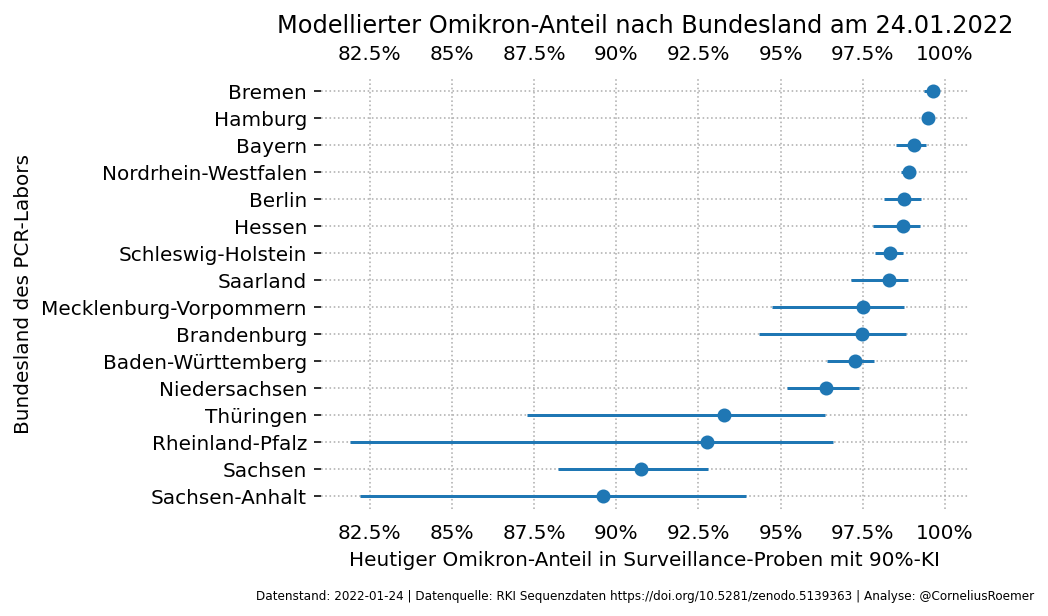

In [21]:
pdf = pd.DataFrame(mcmc_summary['a_area'], index=df_filtered.bundesland.values.categories)
pdf.sort_values(by='median',inplace=True)
errors = ([expit(pdf['median'])-expit(pdf['5.0%']),expit(pdf['95.0%'])-expit(pdf['median'])])
fig, ax = plt.subplots(figsize=(5,4)) 
#sns.set_theme(style="whitegrid")
ax.errorbar(x=expit(pdf['median'].values),y=pdf.index.values.astype(str),xerr=errors,linestyle='None',marker='o')
sns.despine(left=True, bottom=True)
ax.set(title='Title')
ax.set_ylim(-0.5,len(pdf)-0.5)
#ax.set_xscale('logit')
ax.xaxis.set_major_formatter(nice_formatter)
ax.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=True)
ax.tick_params(axis='both', which='minor', labelbottom = False, bottom=False, top = False, labeltop=False)
ax.set(title=f'Modellierter Omikron-Anteil nach Bundesland am {today.strftime("%d.%m.%Y")}')
ax.set_ylabel("Bundesland des PCR-Labors")
ax.set_xlabel("Heutiger Omikron-Anteil in Surveillance-Proben mit 90%-KI")
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.15)
fig.text(0.5, -0.01, f"Datenstand: {str(dt.date.today())} | Datenquelle: RKI Sequenzdaten https://doi.org/10.5281/zenodo.5139363 | Analyse: @CorneliusRoemer", size=6, va="bottom", ha="center")
#fig.savefig("plots/omi_share_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

## Maps
Map postcodes to Bundesländer (~5 Minutes)

In [22]:
#bl = plz.dissolve(by = 'bundesland')
#bl.geometry = bl.simplify(1e-2, preserve_topology=False)
bl = gpd.read_file("data/bundeslaender.geojson").set_index("bundesland")

In [23]:
bl['land'] = "Deutschland"

In [24]:
bl

land  \
bundesland                            
Baden-Württemberg       Deutschland   
Bayern                  Deutschland   
Berlin                  Deutschland   
Brandenburg             Deutschland   
Bremen                  Deutschland   
Hamburg                 Deutschland   
Hessen                  Deutschland   
Mecklenburg-Vorpommern  Deutschland   
Niedersachsen           Deutschland   
Nordrhein-Westfalen     Deutschland   
Rheinland-Pfalz         Deutschland   
Saarland                Deutschland   
Sachsen                 Deutschland   
Sachsen-Anhalt          Deutschland   
Schleswig-Holstein      Deutschland   
Thüringen               Deutschland   

                                                                 geometry  
bundesland                                                                 
Baden-Württemberg       MULTIPOLYGON (((7.63396 47.56122, 7.68592 47.5...  
Bayern                  MULTIPOLYGON (((9.63623 47.60202, 9.74582 47.6...  
Berlin                  POLYGON ((13.73143 52.41981, 13.73412 52.40198...  
Brandenburg             POLYGON ((14.03274 51.47500, 14.06259 51.44542...  
Bremen                  MULTIPOLYGON (((8.96595 53.05772, 8.98022 53.0...  
Hamburg                 MULTIPOLYGON (((10.21828 53.49923, 10.26573 53...  
Hessen                  MULTIPOLYGON (((8.90009 49.48187, 8.89974 49.5...  
Mecklenburg-Vorpommern  MULTIPOLYGON (((11.52874 54.07105, 11.51283 54...  
Niedersachsen           MULTIPOLYGON (((10.36397 51.55606, 10.36689 51...  
Nordrhein-Westfalen     MULTIPOLYGON (((6.16603 50.66186, 6.19337 50.6...  
Rheinland-Pfalz         POLYGON ((8.28766 48.99838, 8.23545 48.96749, ...  
Saarland                POLYGON ((7.31027 49.12958, 7.29356 49.11499, ...  
Sachsen                 POLYGON ((12.23908 50.24698, 12.26616 50.25888...  
Sachsen-Anhalt          POLYGON ((12.19559 51.14146, 12.24134 51.13061...  
Schleswig-Holstein      MULTIPOLYGON (((11.00454 54.45007, 11.01815 54...  
Thüringen               POLYGON ((10.59094 50.27180, 10.60497 50.29310...

In [25]:
de = bl.copy()
de.geometry = de.buffer(1e-2)
de = de.dissolve(by='land')

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


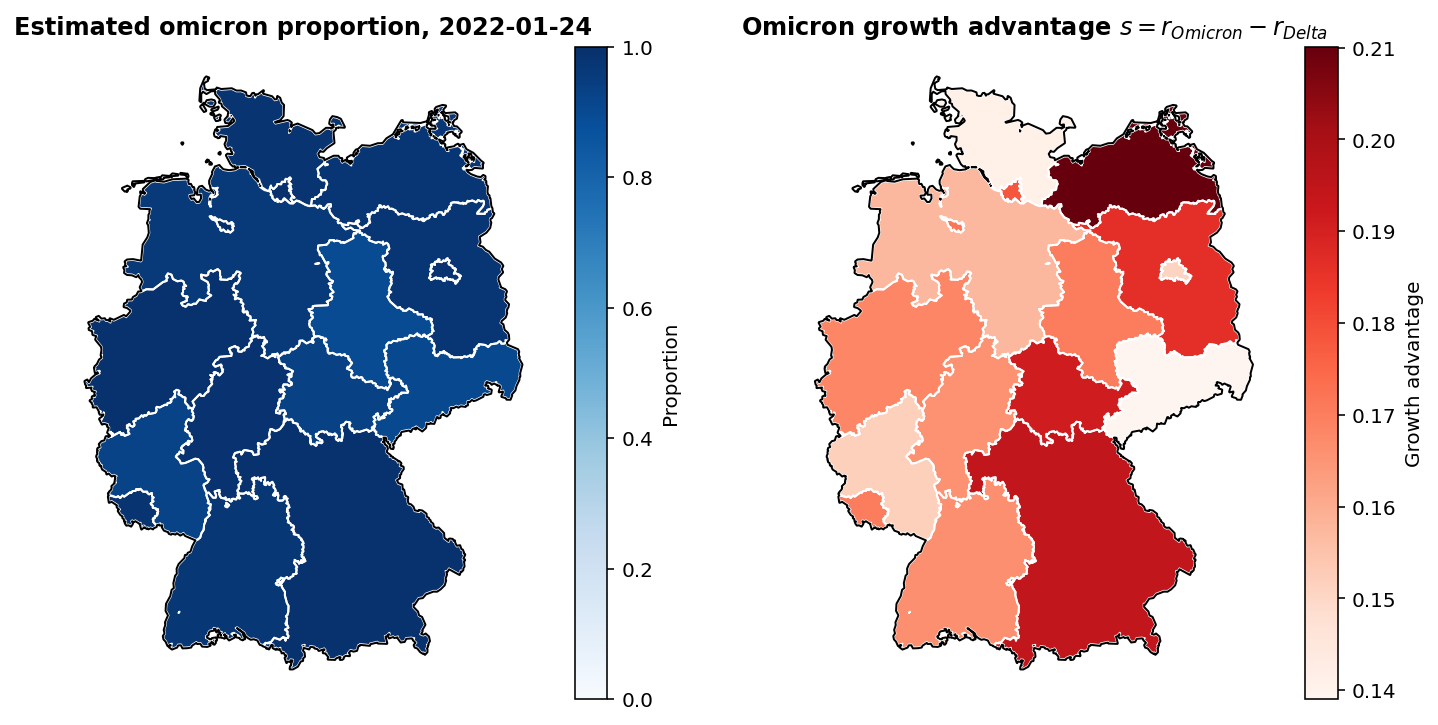

In [26]:
#sns.set_style("white")
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax = ax.flatten()
#sns.reset_orig()
plt.rcParams['figure.facecolor'] = 'white'
pdf = pd.DataFrame({'prop':expit(mcmc_summary['a_area']['mean']),
                    'prop_5%':expit(mcmc_summary['a_area']['5.0%']),
                    'prop_95%':expit(mcmc_summary['a_area']['95.0%']),
                    's': mcmc_summary['b']['mean'],
                    's_sd': mcmc_summary['b']['std']},
                   index=df_filtered.bundesland.values.categories)

b = bl.merge(pdf, left_index=True, right_index=True)
b.plot("prop", lw=1, cmap="Blues", 
            legend=True,
            legend_kwds={'label': "Proportion"},
            figsize=(6,6),
            ax = ax[0],
            vmin = 0,
           vmax = 1
           )
#bl_diag = bl.copy().intersection(diag).rename("geometry").to_frame().merge(pdf, left_index=True, right_index=True)
#bl_diag.plot("prop_95%", lw=1, cmap="Blues", ax=plt.gca())


b.boundary.plot(color='w',lw=1, ax=ax[0])
de.boundary.plot(color='k',lw=1, ax=ax[0])

ax[0].axis('off')
ax[0].set_title(f"Estimated omicron proportion, {np.datetime64('today')}", weight='bold')

b.plot("s", lw=1, cmap="Reds", 
            legend=True,
            legend_kwds={'label': "Growth advantage"},
            figsize=(6,6),
       ax = ax[1]
           )
b.boundary.plot(color='w',lw=1, ax=ax[1])
de.boundary.plot(color='k',lw=1,  ax=ax[1])

ax[1].axis('off')
ax[1].set_title("Omicron growth advantage $s = r_{Omicron} - r_{Delta}$", weight='bold')
fig.savefig("plots/omi_share_map.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [27]:
bar = omi_bl.reset_index()
bar['week'] = bar.date - pd.to_timedelta(bar.date.dt.dayofweek, unit='d')
bar = bar.set_index(['bundesland', 'week','date']).sum(level=(0,1))
bar['prop'] = bar.omi/bar['all']
bar['prop']

bundesland         week      
Baden-Württemberg  2021-11-15    0.000000
                   2021-11-22    0.000637
                   2021-11-29    0.006557
                   2021-12-06    0.009320
                   2021-12-13    0.016447
                                   ...   
Thüringen          2021-12-20    0.000000
                   2021-12-27    0.092308
                   2022-01-03    0.347222
                   2022-01-10    0.388889
                   2022-01-17         NaN
Name: prop, Length: 160, dtype: float64

(2707.0, 2717.0)

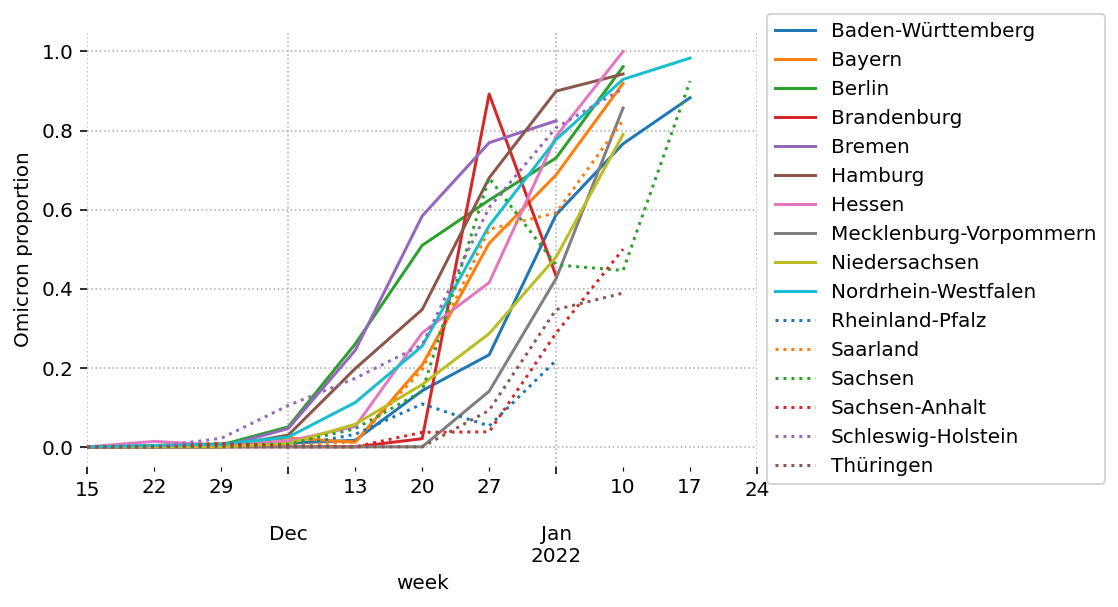

In [28]:
for i,r in enumerate(bar.index.levels[0]):
    bar.loc[r]['prop'].plot( label=r, ls = "-" if i <10 else ":")
#foo.mean(level=1)['prop'].plot()
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.ylabel("Omicron proportion")
plt.xlim((None,np.datetime64("today")))

In [29]:
bar.loc[:,'2021-12-20':,:]

all  omi  days  sending_area  sending_pc_ID  \
bundesland        week                                                      
Baden-Württemberg 2021-12-20  556   79 -2912           637           7966   
                  2021-12-27  786  183 -2275           637           7966   
                  2022-01-03  705  414 -1638           637           7966   
                  2022-01-10  467  358 -1001           637           7966   
                  2022-01-17   94   83  -169           182           2276   
...                           ...  ...   ...           ...            ...   
Thüringen         2021-12-20  166    0  -896           189           2352   
                  2021-12-27  195   18  -700           189           2352   
                  2022-01-03  144   50  -504           189           2352   
                  2022-01-10   18    7  -308           189           2352   
                  2022-01-17    0    0   -52            54            672   

                                  prop  
bundesland        week                  
Baden-Württemberg 2021-12-20  0.142086  
                  2021-12-27  0.232824  
                  2022-01-03  0.587234  
                  2022-01-10  0.766595  
                  2022-01-17  0.882979  
...                                ...  
Thüringen         2021-12-20  0.000000  
                  2021-12-27  0.092308  
                  2022-01-03  0.347222  
                  2022-01-10  0.388889  
                  2022-01-17       NaN  

[80 rows x 6 columns]

In [30]:
cases = pd.read_csv("https://media.githubusercontent.com/media/robert-koch-institut/SARS-CoV-2_Infektionen_in_Deutschland/master/Aktuell_Deutschland_SarsCov2_Infektionen.csv",  index_col=[0,1,2,4], parse_dates=True)

In [31]:
cases = cases['AnzahlFall'].sum(level=(0,3)).sort_index()

In [32]:
s="""01  Schleswig-Holstein
02  Hamburg
03  Niedersachsen
04  Bremen
05  Nordrhein-Westfalen
06  Hessen
07  Rheinland-Pfalz
08  Baden-Württemberg
09  Bayern
10  Saarland
11  Berlin
12  Brandenburg
13  Mecklenburg-Vorpommern
14  Sachsen
15  Sachsen-Anhalt
16  Thüringen"""
b={int(x.split()[0]): x.split()[1] for x in s.split("\n")}

In [33]:
cases_land = cases.reset_index()
cases_land['bundesland'] = (cases_land.IdLandkreis/1000).astype("int")
cases_land = cases_land.set_index(['bundesland', 'IdLandkreis','Refdatum']).sum(level=(0,2)).sort_index()
cases_land = cases_land.rename(index=b).sort_index()
cases_land

AnzahlFall
bundesland        Refdatum              
Baden-Württemberg 2020-01-05           1
                  2020-01-06           2
                  2020-01-07           1
                  2020-01-12           1
                  2020-01-24           1
...                                  ...
Thüringen         2022-01-19         814
                  2022-01-20         731
                  2022-01-21         640
                  2022-01-22         541
                  2022-01-23         125

[11356 rows x 1 columns]

Text(0, 0.5, 'cases')

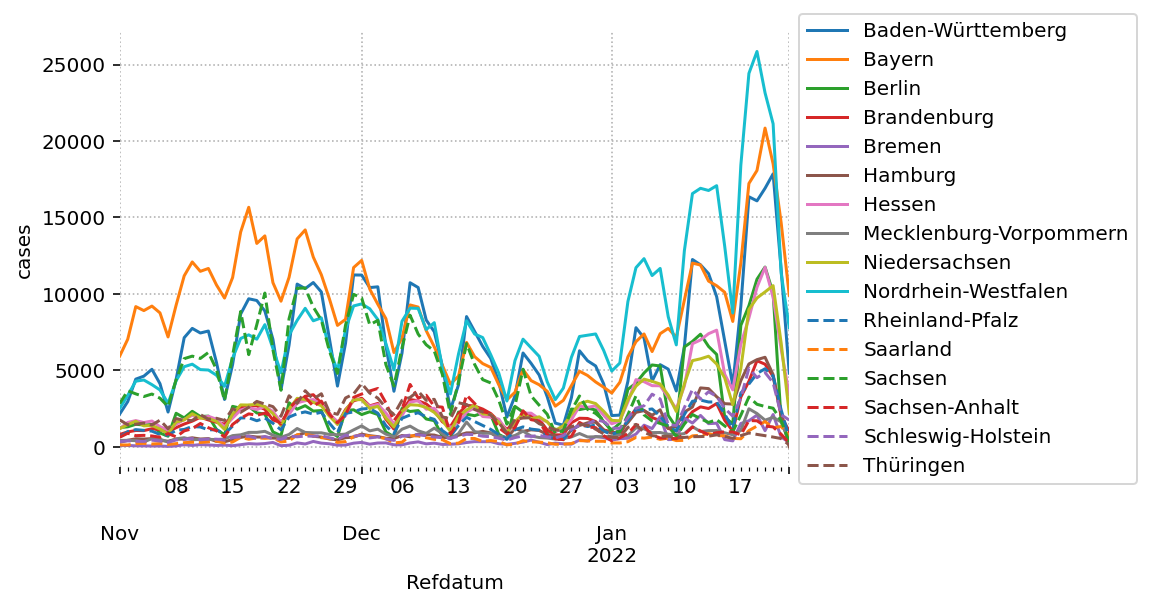

In [34]:
for i,r in enumerate(cases_land.index.levels[0]):
    cases_land.loc[r].loc["2021-11-01":,'AnzahlFall'].plot(label=r, ls="-" if i<10 else "--")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.ylabel('cases')
#plt.xlim("")

In [35]:
bar

all  omi  days  sending_area  sending_pc_ID  \
bundesland        week                                                       
Baden-Württemberg 2021-11-15   219    0 -1677           182           2276   
                  2021-11-22  1569    1 -5460           637           7966   
                  2021-11-29   915    6 -4823           637           7966   
                  2021-12-06  1073   10 -4186           637           7966   
                  2021-12-13   912   15 -3549           637           7966   
...                            ...  ...   ...           ...            ...   
Thüringen         2021-12-20   166    0  -896           189           2352   
                  2021-12-27   195   18  -700           189           2352   
                  2022-01-03   144   50  -504           189           2352   
                  2022-01-10    18    7  -308           189           2352   
                  2022-01-17     0    0   -52            54            672   

                                  prop  
bundesland        week                  
Baden-Württemberg 2021-11-15  0.000000  
                  2021-11-22  0.000637  
                  2021-11-29  0.006557  
                  2021-12-06  0.009320  
                  2021-12-13  0.016447  
...                                ...  
Thüringen         2021-12-20  0.000000  
                  2021-12-27  0.092308  
                  2022-01-03  0.347222  
                  2022-01-10  0.388889  
                  2022-01-17       NaN  

[160 rows x 6 columns]

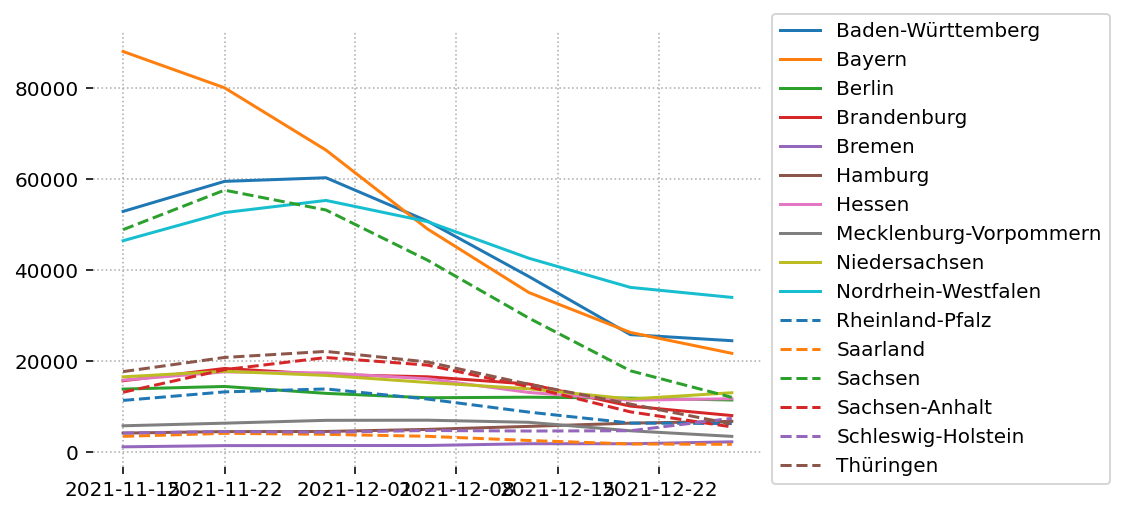

In [36]:
for i,r in enumerate(cases_land.index.levels[0]):
    c = cases_land.loc[r,"2021-11-01":"2021-12-31",:].reset_index()
    c['week'] = c.Refdatum - pd.to_timedelta(c.Refdatum.dt.dayofweek, unit='d') 
    c = c.set_index(['week','Refdatum']).sum(level=0).merge(bar.loc[r], left_index=True, right_index=True)
    plt.plot(c.index, c['AnzahlFall'] , label=r, ls="-" if i < 10 else "--")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

Text(0, 0.5, 'Omicron cases')

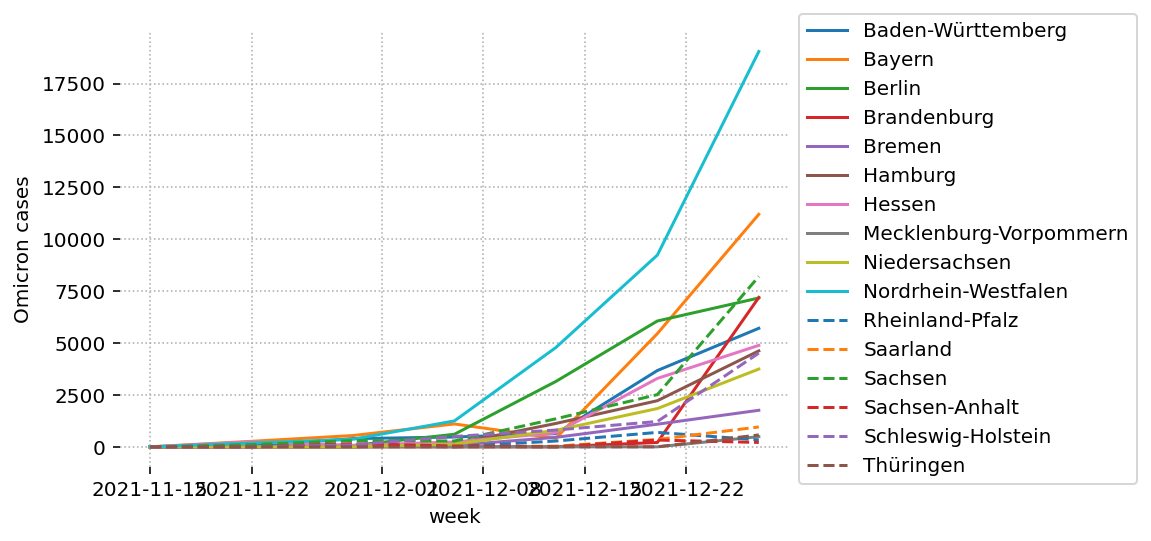

In [37]:
for i,r in enumerate(cases_land.index.levels[0]):
    c = cases_land.loc[r,"2021-11-01":"2021-12-31",:].reset_index()
    c['week'] = c.Refdatum - pd.to_timedelta(c.Refdatum.dt.dayofweek, unit='d') 
    c = c.set_index(['week','Refdatum']).sum(level=0).merge(bar.loc[r], left_index=True, right_index=True)
    plt.plot(c.index, c['AnzahlFall'] * c['prop'], label=r, ls="-" if i < 10 else "--")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel('week')
plt.ylabel("Omicron cases")

In [38]:
bar

all  omi  days  sending_area  sending_pc_ID  \
bundesland        week                                                       
Baden-Württemberg 2021-11-15   219    0 -1677           182           2276   
                  2021-11-22  1569    1 -5460           637           7966   
                  2021-11-29   915    6 -4823           637           7966   
                  2021-12-06  1073   10 -4186           637           7966   
                  2021-12-13   912   15 -3549           637           7966   
...                            ...  ...   ...           ...            ...   
Thüringen         2021-12-20   166    0  -896           189           2352   
                  2021-12-27   195   18  -700           189           2352   
                  2022-01-03   144   50  -504           189           2352   
                  2022-01-10    18    7  -308           189           2352   
                  2022-01-17     0    0   -52            54            672   

                                  prop  
bundesland        week                  
Baden-Württemberg 2021-11-15  0.000000  
                  2021-11-22  0.000637  
                  2021-11-29  0.006557  
                  2021-12-06  0.009320  
                  2021-12-13  0.016447  
...                                ...  
Thüringen         2021-12-20  0.000000  
                  2021-12-27  0.092308  
                  2022-01-03  0.347222  
                  2022-01-10  0.388889  
                  2022-01-17       NaN  

[160 rows x 6 columns]

In [39]:
cases_land

AnzahlFall
bundesland        Refdatum              
Baden-Württemberg 2020-01-05           1
                  2020-01-06           2
                  2020-01-07           1
                  2020-01-12           1
                  2020-01-24           1
...                                  ...
Thüringen         2022-01-19         814
                  2022-01-20         731
                  2022-01-21         640
                  2022-01-22         541
                  2022-01-23         125

[11356 rows x 1 columns]

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


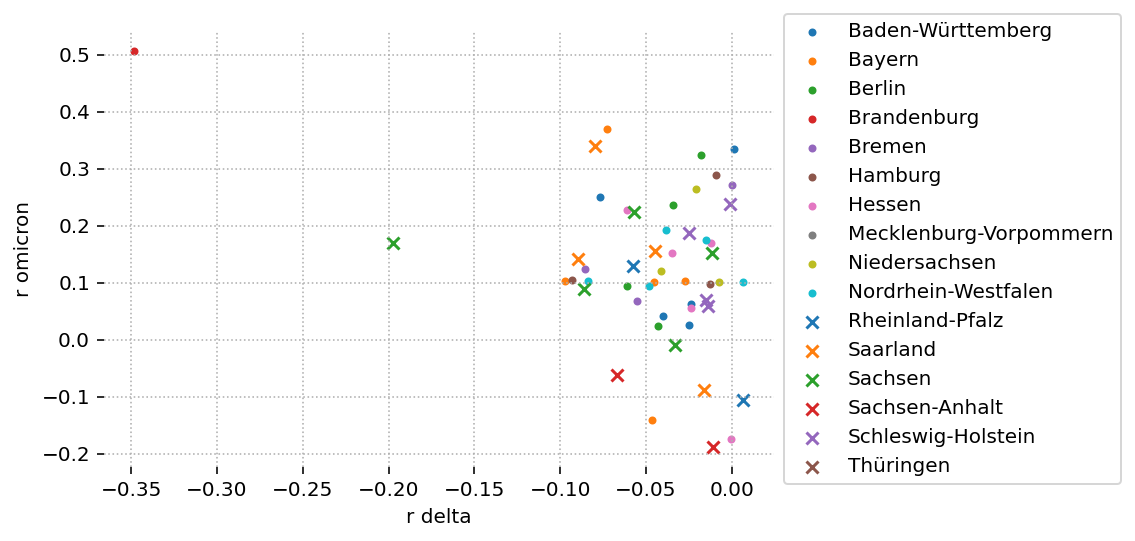

In [40]:
for i,r in enumerate(cases_land.index.levels[0]):
    c = cases_land.loc[r,"2021-11-01":"2021-12-31",:].reset_index()
    c['week'] = c.Refdatum - pd.to_timedelta(c.Refdatum.dt.dayofweek, unit='d') 
    c = c.set_index(['week','Refdatum']).sum(level=0).merge(bar.loc[r], left_index=True, right_index=True)
    y = c['AnzahlFall'] * c['prop']
    x = c['AnzahlFall'] * (1-c['prop'])
    dx = np.log(x[1:]/x[:-1].values)/7
    dy = np.log(y[1:]/y[:-1].values)/7
    plt.scatter(dx, dy, label=r, marker = "." if i <10 else "x")
plt.xlabel("r delta")
plt.ylabel("r omicron")
    
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

In [41]:
c = cases_land.loc[:,"2021-12-08":"2021-12-21",:] / cases_land.loc[:,"2021-12-01":"2021-12-14",:].values
foo = np.log(c).mean(level=0).rename(columns={'AnzahlFall':'r'}) / 7
foo['r_sd'] = np.log(c).std(level=0).values / 7

In [42]:
foo = foo.merge(pdf, left_index=True, right_index=True)

<AxesSubplot:xlabel='r', ylabel='s'>

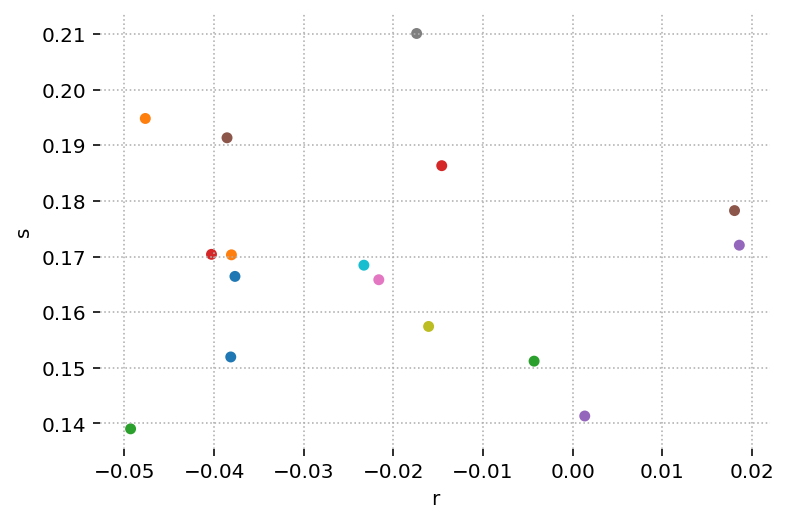

In [43]:
foo.plot.scatter("r","s", c = [f'C{i}' for i in range(foo.shape[0])])
#plt.legend()

Text(0, 0.5, 'Growth rate Omicron')

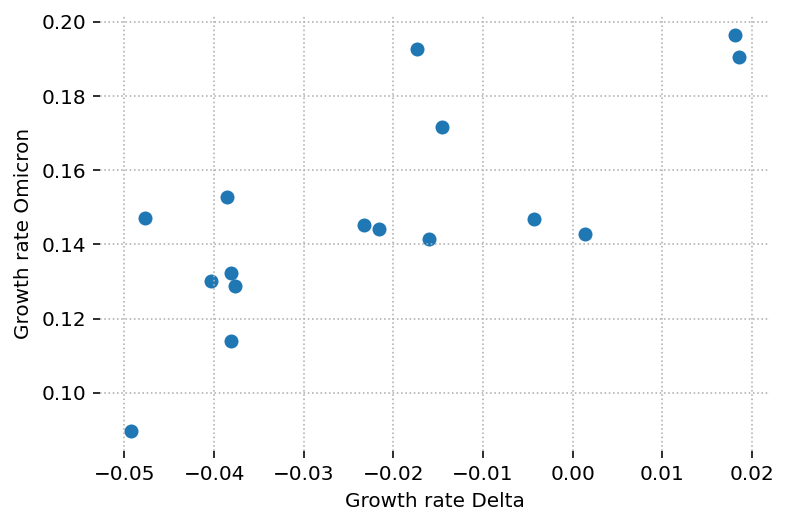

In [44]:
plt.scatter(foo['r'], foo['s'] + foo['r'])
plt.xlabel("Growth rate Delta")
plt.ylabel("Growth rate Omicron")

In [45]:
foo.to_csv(f"Germany_SGTF_{np.datetime64('today')}.csv")

In [46]:
capita = pd.read_csv("data/12411-0010.csv", index_col=0)["Population"]
capita

Baden-Württemberg         11103043
Bayern                    13140183
Berlin                     3664088
Brandenburg                2531071
Bremen                      680130
Hamburg                    1852478
Hessen                     6293154
Mecklenburg-Vorpommern     1610774
Niedersachsen              8003421
Nordrhein-Westfalen       17925570
Rheinland-Pfalz            4098391
Saarland                    983991
Sachsen                    4056941
Sachsen-Anhalt             2180684
Schleswig-Holstein         2910875
Thüringen                  2120237
Name: Population, dtype: int64

In [47]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

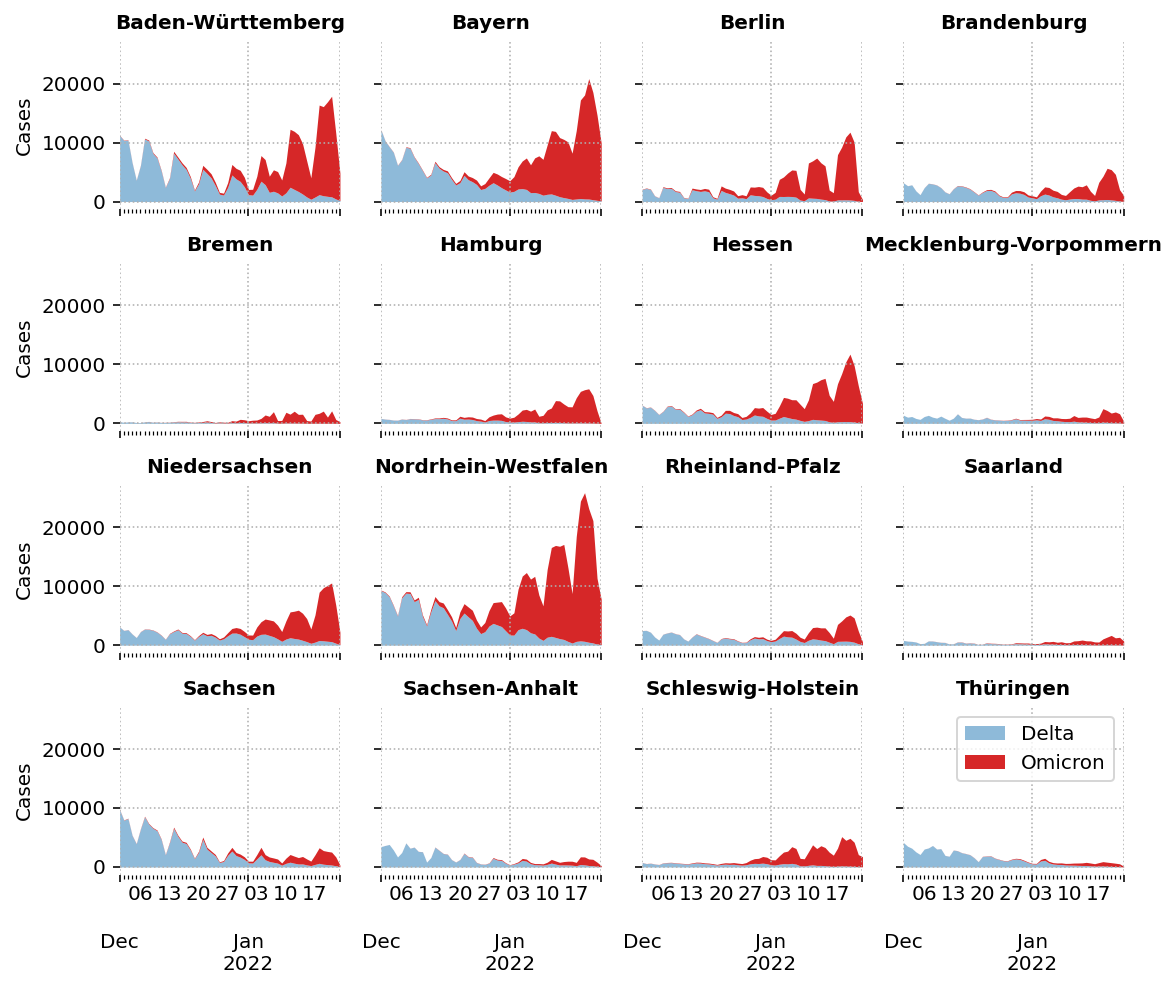

In [48]:
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
for i,r in enumerate(prop_bl.index.levels[0]):
    y = cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] 
    y.index.name = 'date'
    x = prop_bl.loc[r,:,:][0].unstack()
    z = ((1-x[0.5]) * y)
    s = pd.Series(np.exp(lowess(np.log(z), z.index)[:,1]), z.dropna().index)
    y.plot(ax=ax[i], ls="", label="")
    ax[i].fill_between(z.index, y-x[0.5]*y, color='C0', alpha=.5, lw=0, label="Delta")
    ax[i].fill_between(z.index, y-x[0.5]*y, y-x[0.05]+x[0.05], color='C3', lw=0, label="Omicron")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    #ax[i].plot(s.index, s, ls="-", c='C0')
    #s.iloc[-7:-1]
    #ax[i].plot(x.index, s/(1-x[0.5]), ls="-", c='C3')
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases")
    ax[i].grid(ls=":")
    for a in ax[i].spines.values():
        a.set_visible(False)
ax[-1].legend(title=None)
plt.tight_layout()

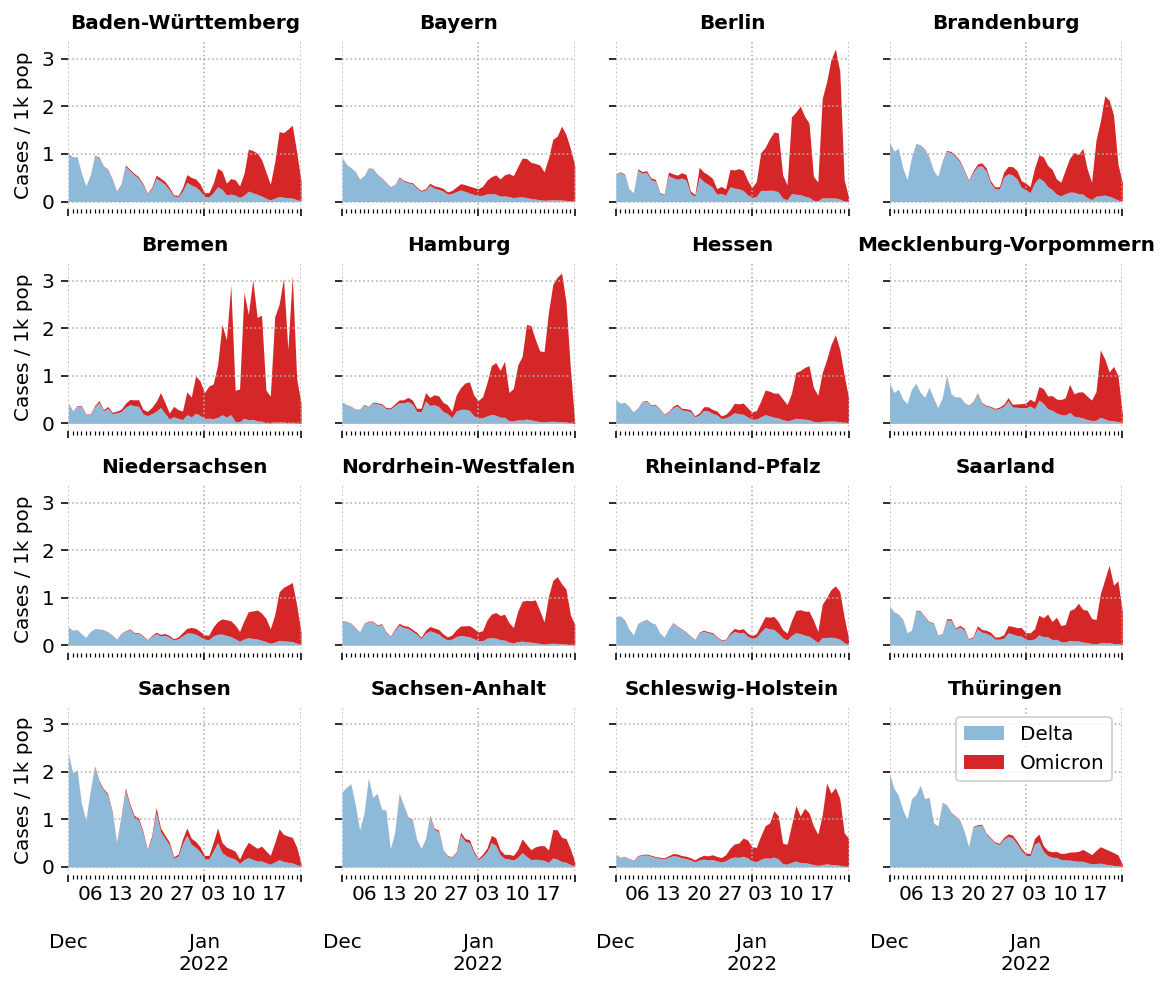

In [49]:
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
for i,r in enumerate(prop_bl.index.levels[0]):
    y = cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000 #* 700
    y.index.name = 'date'
    x = prop_bl.loc[r,:,:][0].unstack()
    z = x[0.5] * y
    y.plot(ax=ax[i], ls="", label="")
    ax[i].fill_between(z.index, y-x[0.5]*y, color='C0', alpha=.5, lw=0, label="Delta")
    ax[i].fill_between(z.index, y-x[0.5]*y, y-x[0.05]+x[0.05], color='C3', lw=0, label="Omicron")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases / 1k pop")
    ax[i].grid(ls=":")
    for a in ax[i].spines.values():
        a.set_visible(False)
ax[-1].legend(title=None)
plt.tight_layout()
fig.savefig("plots/omi_abs_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

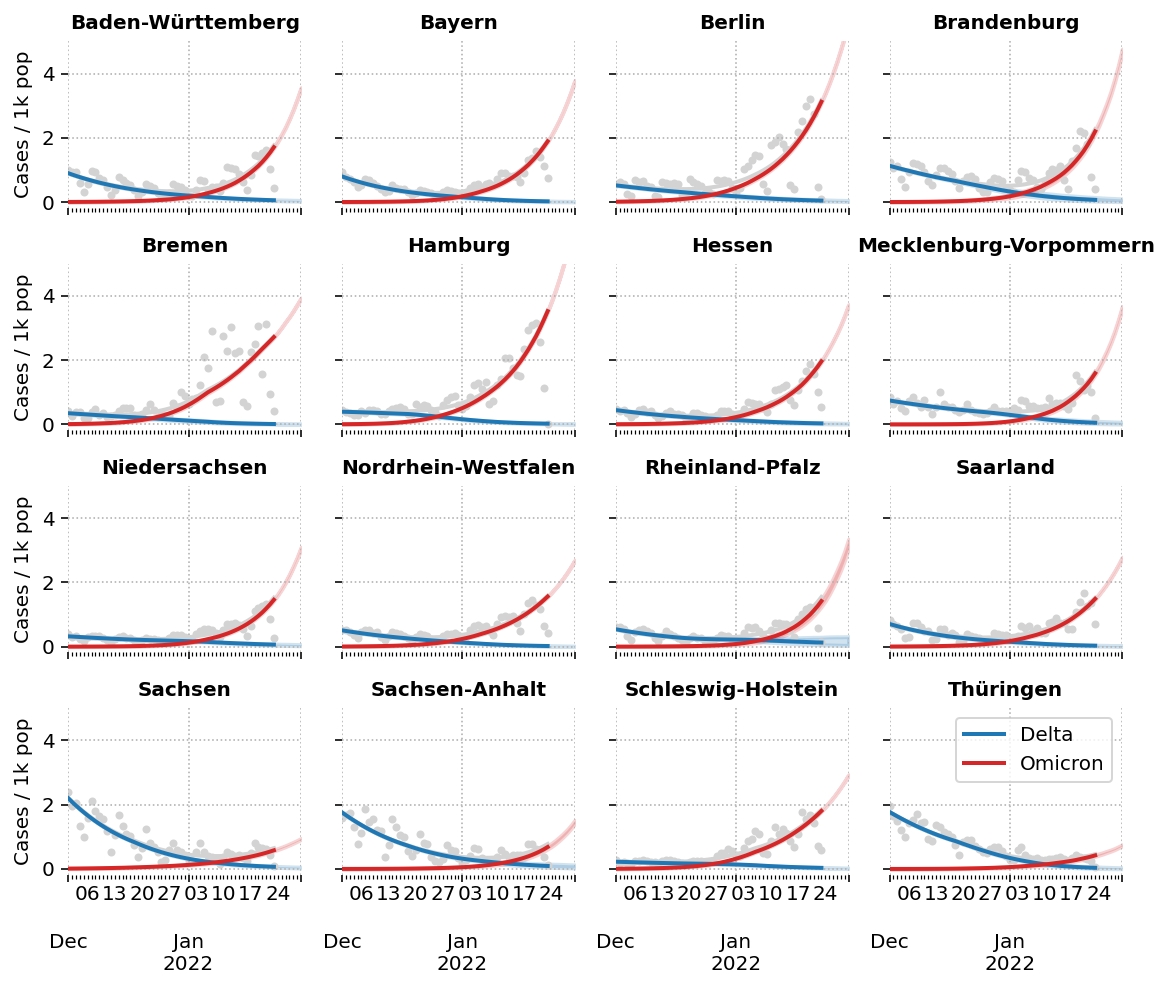

In [50]:
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
e = {}
f = {}
for i,r in enumerate(prop_bl.index.levels[0]):
    y = cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000
    y.index.name = 'date'
    x = prop_bl.loc[r,:,:][0].unstack()
    z = ((1-x[0.5]) * y)
    s = pd.Series(np.exp(lowess(np.log(z), z.index)[:,1]), z.dropna().index)
    y.plot(ax=ax[i], ls="", label="")
    #ax[i].fill_between(s.index, s, color='C0', alpha=.5, lw=0, label="Delta")
    #ax[i].fill_between(x.index, s*x[0.5]/x[0.5], s/(1-x[0.5]), color='C3', lw=0, label="Omicron")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].plot(x.index, s/(1-x[0.5]), ls="-", c='lightgrey', label="", lw=2)
    ax[i].plot(s.index, s, ls="-", c='C0', label="Delta", lw=2)
    ax[i].plot(x.index, s/(1-x[0.5]) * x[.5], ls="-", c='C3', label="Omicron", lw=2)
    
    s1 = pd.Series(np.exp(np.log(s).diff().iloc[-7:].mean() * np.arange(1,8) + np.log(s)[-1]), index=s.index[-1] + np.arange(1,8).astype("timedelta64[D]"))
    #ax[i].plot(x.index, s1/(1-x[0.5]), ls=":", c='lightgrey', label="", lw=2)
    #ax[i].plot(s1.index, s1, ls=":", c='C0', label="", lw=2)
    #ax[i].plot(x.index, s1/(1-x[0.5]) * x[.5], ls=":", c='C3', label="", lw=2)
    
    s = pd.concat([s,s1])
    ax[i].fill_between(x.index, s/(1-x[0.5]) * x[0.05] , s/(1-x[0.5]) * x[0.95], color='C3', lw=2, alpha=0.2)
    ax[i].fill_between(x.index, s/(1-x[0.5]) * (1-x[0.05]) , s/(1-x[0.5]) * (1-x[0.95]) , color='C0', lw=2, alpha=0.2)

    
    ax[i].scatter(y.index, y, marker=".",c='lightgrey', label="")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases / 1k pop")
    ax[i].grid(ls=":")
    ax[i].set_xlim((None, s1.index[-1]))
    ax[i].set_ylim((None, 5))
    for a in ax[i].spines.values():
        a.set_visible(False)
    e[r] = s/(1-x[0.5][s.index]) * capita[r] / 1000
    f[r] = s * capita[r] / 1000
ax[-1].legend(title=None)
plt.tight_layout()
fig.savefig("plots/omi_abs_by_area_fit.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

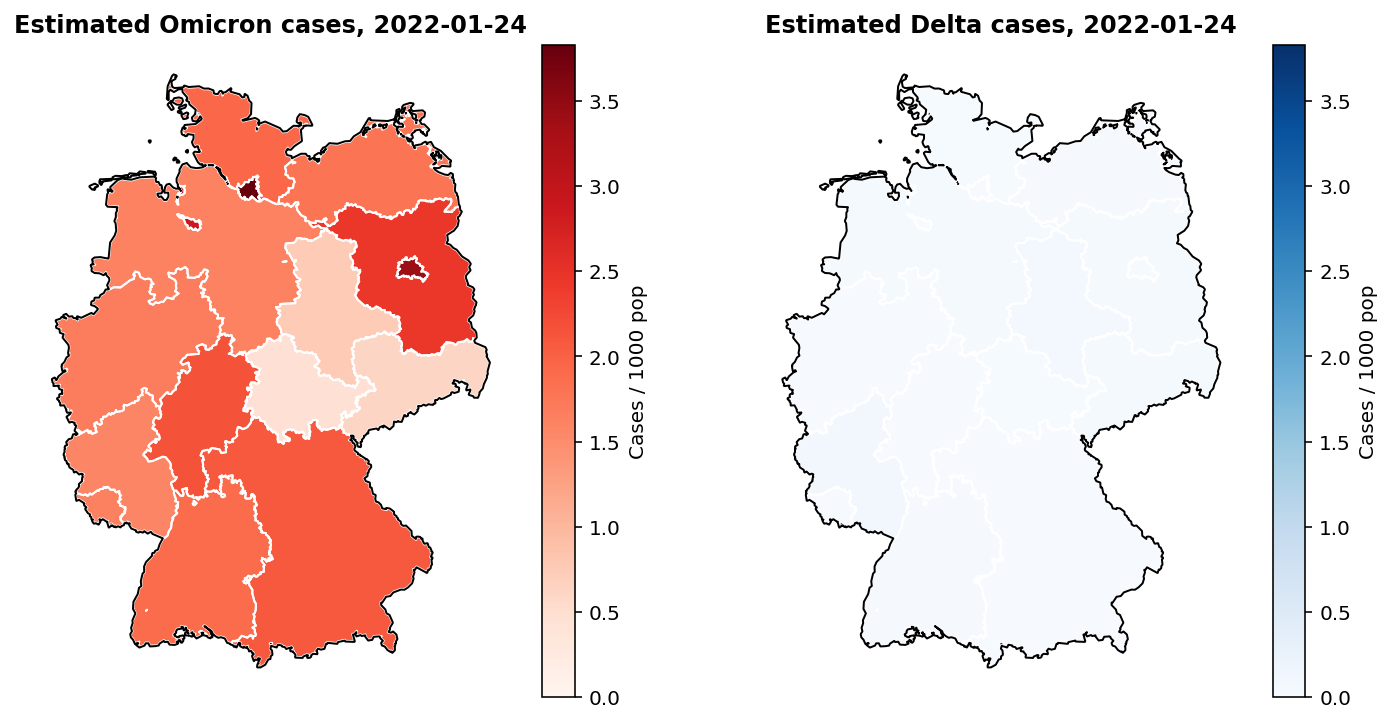

In [51]:
d = pd.DataFrame(f).loc[np.datetime64("today")] / capita * 1000
o = pd.DataFrame(e).loc[np.datetime64("today")] / capita * 1000 - d

y = pd.DataFrame({'Omicron':o, 'Delta':d})

fig, ax = plt.subplots(1,2, figsize=(12,6))
ax = ax.flatten()
#sns.reset_orig()
plt.rcParams['figure.facecolor'] = 'white'

b = bl.merge(y, left_index=True, right_index=True)
b.plot("Omicron", lw=1, cmap="Reds", 
            legend=True,
            legend_kwds={'label': "Cases / 1000 pop"},
            figsize=(6,6),
            ax = ax[0],
       vmin = 0,
       vmax = y.max().max()
           )
#bl_diag = bl.copy().intersection(diag).rename("geometry").to_frame().merge(pdf, left_index=True, right_index=True)
#bl_diag.plot("prop_95%", lw=1, cmap="Blues", ax=plt.gca())


b.boundary.plot(color='w',lw=1, ax=ax[0])
de.boundary.plot(color='k',lw=1, ax=ax[0])

ax[0].axis('off')
ax[0].set_title(f"Estimated Omicron cases, {np.datetime64('today')}", weight='bold')

b.plot("Delta", lw=1, cmap="Blues", 
            legend=True,
            legend_kwds={'label': "Cases / 1000 pop"},
            figsize=(6,6),
       ax = ax[1],
              vmin = 0,
       vmax = y.max().max()
           )
b.boundary.plot(color='w',lw=1, ax=ax[1])
de.boundary.plot(color='k',lw=1,  ax=ax[1])

ax[1].axis('off')
ax[1].set_title(f"Estimated Delta cases, {np.datetime64('today')}", weight='bold')
fig.savefig("plots/omi_share_map.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

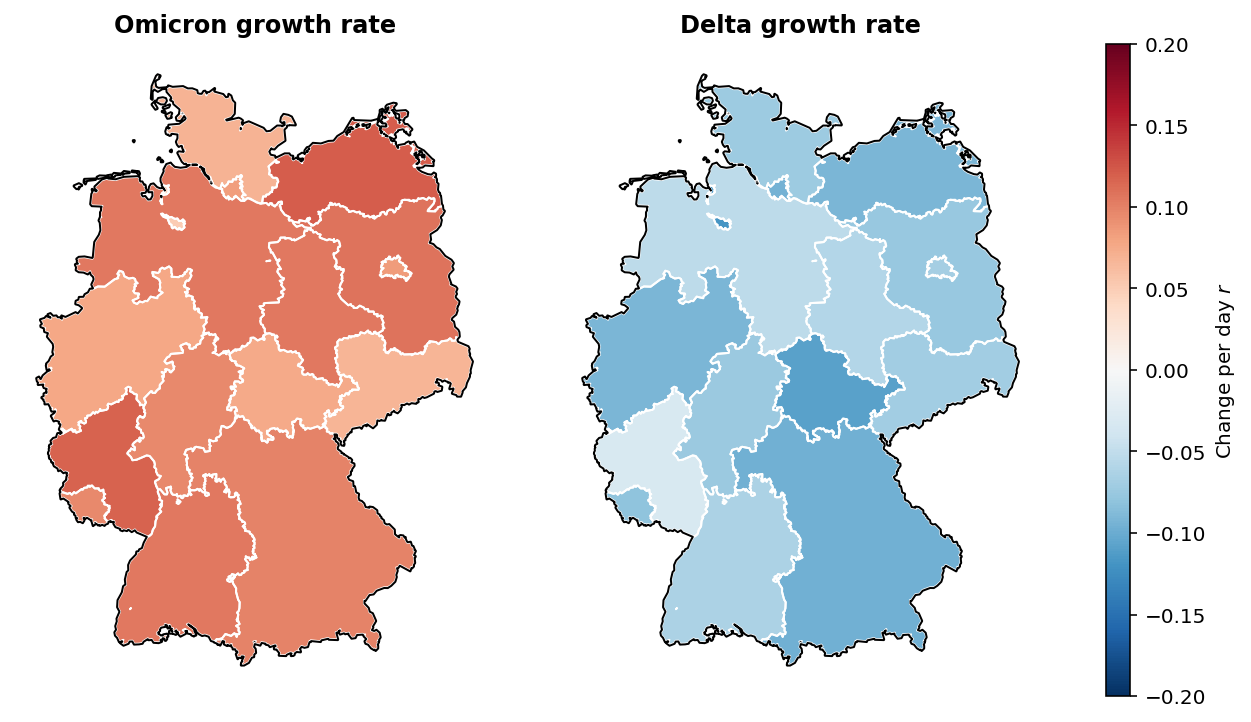

In [52]:
r = pd.DataFrame({'Omicron':np.log(pd.DataFrame(e) - pd.DataFrame(f)).diff().loc[np.datetime64("today"),:], 
                  'Delta': np.log(pd.DataFrame(f)).diff().loc[np.datetime64("today"),:]})

fig, ax = plt.subplots(1,3, figsize=(10,6), gridspec_kw={'width_ratios': [2, 2, 0.1]})
ax = ax.flatten()

r = bl.merge(r, left_index=True, right_index=True)

for i, v in enumerate(r.columns[-2:]):
    r.plot(v, lw=1, cmap="RdBu_r", 
                legend=i>0,
                cax = ax[2],
                legend_kwds={'label': "Change per day $r$"},
                figsize=(6,6),
                ax = ax[i],
           vmin = -0.2,
           vmax = 0.2,#y.max().max()
               )
    #bl_diag = bl.copy().intersection(diag).rename("geometry").to_frame().merge(pdf, left_index=True, right_index=True)
    #bl_diag.plot("prop_95%", lw=1, cmap="Blues", ax=plt.gca())
    ax[i].set_title( f"{v} growth rate", weight='bold')

    ax[i].axis("off")
    b.boundary.plot(color='w',lw=1, ax=ax[i])
    de.boundary.plot(color='k',lw=1, ax=ax[i])

#ax2 =ax[2].secondary_yaxis('left', functions=(lambda x: np.log(2)/x, lambda x: np.log(2)/x))
#ax2.set_yticks(np.array([-4,-5,-6,-7,-8,-9, -10,-100, 4,5,6,7,8,9,10,100]))
#ax2.set_ylabel('Doubling time [days]')

<AxesSubplot:title={'center':'Germany'}, xlabel='date', ylabel='Omicron proportion'>

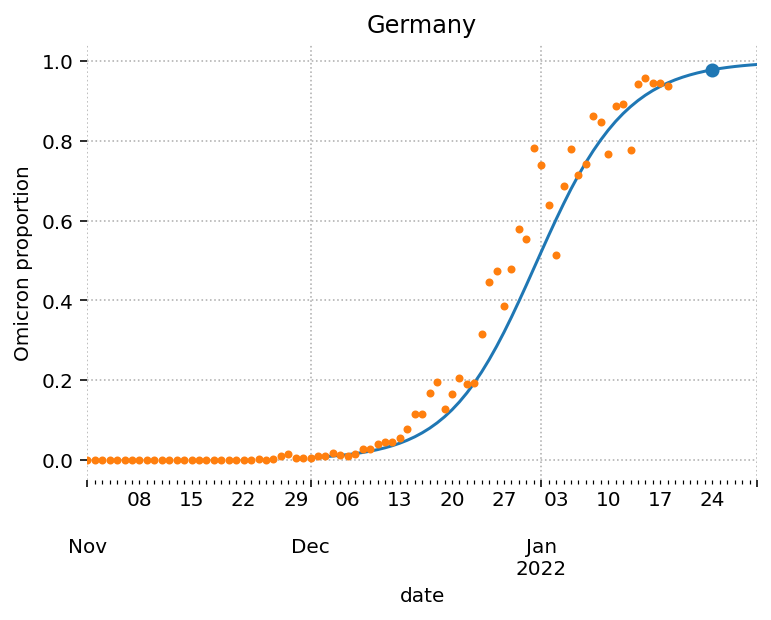

In [53]:
y = (1 - pd.DataFrame(f).sum(1) /pd.DataFrame(e).sum(1))
y.plot(ylabel = "Omicron proportion", xlabel="", title="Germany")
plt.scatter(np.datetime64('today'), y.loc[np.datetime64('today')])
foo = pd.crosstab(df.date, df.lineage.cat.remove_unused_categories())
(foo[ ['BA.1','BA.2','BA.3','B.1.1.529']].sum(1)/foo.sum(1)).plot(ls="",marker='.', legend=None)
#plt.yscale('logit')

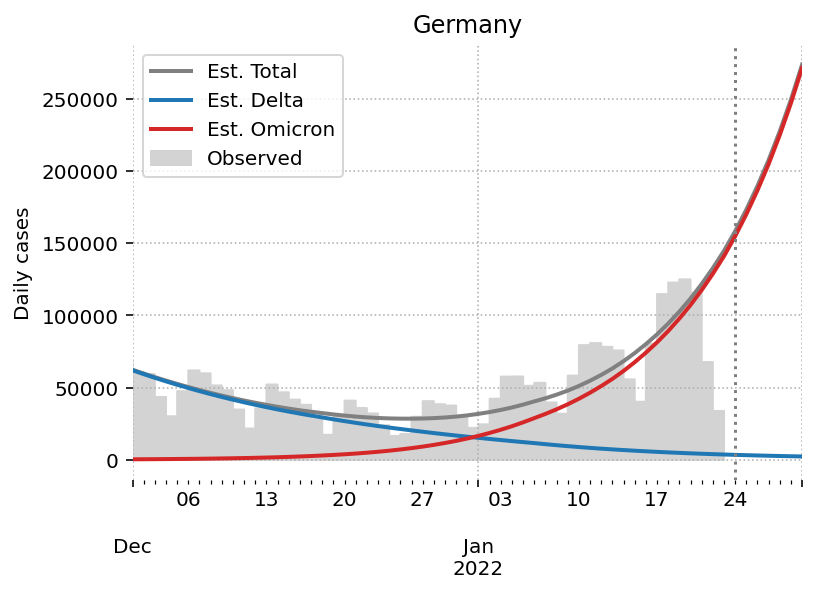

In [54]:
y = pd.DataFrame(e).sum(1)
y.plot(ylabel = "Daily cases", xlabel="", title="Germany", c="grey", lw=2, label='Est. Total')
pd.DataFrame(f).sum(1).plot(label="Est. Delta", c="C0", lw=2)
(pd.DataFrame(e) - pd.DataFrame(f)).sum(1).plot(label="Est. Omicron", c="C3", lw=2)
#plt.scatter(np.datetime64('today'), y.loc[np.datetime64('today')])
#cases_land.sum(level=1).sort_index().rename(columns={'AnzahlFall':'Observed'}).plot(ls="", marker=".", markersize=10, ax=plt.gca(), xlabel="", label="Observed", c="lightgrey", zorder=0)
z=cases_land.sum(level=1).sort_index().rename(columns={'AnzahlFall':'Observed'})
plt.fill_between(z.index, z.Observed, color='lightgrey', zorder=0, step='pre', label='Observed')
plt.xlim(("2021-12-01",None))
plt.axvline(np.datetime64('today'), c="grey", ls=":")
plt.legend()

In [55]:
np.log(2) / r.iloc[:,-2:] 

Omicron      Delta
bundesland                                  
Baden-Württemberg        6.592909 -11.085290
Bayern                   6.933595  -7.245550
Berlin                   8.166178 -10.288146
Brandenburg              6.412226  -9.204687
Bremen                  13.449391  -5.852319
Hamburg                  8.293933  -7.346261
Hessen                   7.258273  -9.362968
Mecklenburg-Vorpommern   5.746903  -7.627640
Niedersachsen            6.555645 -13.366716
Nordrhein-Westfalen      9.027564  -7.617827
Rheinland-Pfalz          5.873143 -22.080215
Saarland                 7.264423  -8.629003
Sachsen                 10.241479  -9.914796
Sachsen-Anhalt           6.576544 -11.837408
Schleswig-Holstein      10.027539  -9.537444
Thüringen                9.175066  -6.382519

In [56]:
r

land  \
bundesland                            
Baden-Württemberg       Deutschland   
Bayern                  Deutschland   
Berlin                  Deutschland   
Brandenburg             Deutschland   
Bremen                  Deutschland   
Hamburg                 Deutschland   
Hessen                  Deutschland   
Mecklenburg-Vorpommern  Deutschland   
Niedersachsen           Deutschland   
Nordrhein-Westfalen     Deutschland   
Rheinland-Pfalz         Deutschland   
Saarland                Deutschland   
Sachsen                 Deutschland   
Sachsen-Anhalt          Deutschland   
Schleswig-Holstein      Deutschland   
Thüringen               Deutschland   

                                                                 geometry  \
bundesland                                                                  
Baden-Württemberg       MULTIPOLYGON (((7.63396 47.56122, 7.68592 47.5...   
Bayern                  MULTIPOLYGON (((9.63623 47.60202, 9.74582 47.6...   
Berlin                  POLYGON ((13.73143 52.41981, 13.73412 52.40198...   
Brandenburg             POLYGON ((14.03274 51.47500, 14.06259 51.44542...   
Bremen                  MULTIPOLYGON (((8.96595 53.05772, 8.98022 53.0...   
Hamburg                 MULTIPOLYGON (((10.21828 53.49923, 10.26573 53...   
Hessen                  MULTIPOLYGON (((8.90009 49.48187, 8.89974 49.5...   
Mecklenburg-Vorpommern  MULTIPOLYGON (((11.52874 54.07105, 11.51283 54...   
Niedersachsen           MULTIPOLYGON (((10.36397 51.55606, 10.36689 51...   
Nordrhein-Westfalen     MULTIPOLYGON (((6.16603 50.66186, 6.19337 50.6...   
Rheinland-Pfalz         POLYGON ((8.28766 48.99838, 8.23545 48.96749, ...   
Saarland                POLYGON ((7.31027 49.12958, 7.29356 49.11499, ...   
Sachsen                 POLYGON ((12.23908 50.24698, 12.26616 50.25888...   
Sachsen-Anhalt          POLYGON ((12.19559 51.14146, 12.24134 51.13061...   
Schleswig-Holstein      MULTIPOLYGON (((11.00454 54.45007, 11.01815 54...   
Thüringen               POLYGON ((10.59094 50.27180, 10.60497 50.29310...   

                         Omicron     Delta  
bundesland                                  
Baden-Württemberg       0.105135 -0.062529  
Bayern                  0.099969 -0.095665  
Berlin                  0.084880 -0.067373  
Brandenburg             0.108098 -0.075304  
Bremen                  0.051537 -0.118440  
Hamburg                 0.083573 -0.094354  
Hessen                  0.095498 -0.074031  
Mecklenburg-Vorpommern  0.120612 -0.090873  
Niedersachsen           0.105733 -0.051856  
Nordrhein-Westfalen     0.076781 -0.090990  
Rheinland-Pfalz         0.118020 -0.031392  
Saarland                0.095417 -0.080328  
Sachsen                 0.067680 -0.069910  
Sachsen-Anhalt          0.105397 -0.058556  
Schleswig-Holstein      0.069124 -0.072676  
Thüringen               0.075547 -0.108601

In [57]:
#bl[["geometry","land"]][1:].to_file("data/bundeslaender.geojson", driver='GeoJSON')